Ilyes Justin m12001643 <br>
Seidl Stefan m11804717 <br>
Wagermaier Daniel m01605389

# Definition of input files

In [1]:
# --- Execution mandatory --- #
# Filename need to be defined:
digits_train_filename = '../data/alldigits.csv'

# Calc1: Read data

In [2]:
# --- Execution mandatory --- #

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint

test_size = 0.3

# import Data
df = pd.read_csv(digits_train_filename)
data = df.to_numpy()
scalar = StandardScaler()

X = data[:, :-1]
y = data[:, -1]

# Splitting (no val_set because of cross-validation in gridSearchCV)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=10)

# Standardizing (mean and SDD only from train_data)
scalar.fit(X_train)
X_train = scalar.transform(X_train)
X_test = scalar.transform(X_test)


# Explore

### Support Vector Classification - Hyperparameter Search

In order for us to attain the best possible accuracy for each Support Vector Machine Classifier in sklearn, we would need to implement a method where different variations of hyperparameters would all be tested on the classifiers to deliver the most accurate result. An optimal solution to this problem was by using the GridSearchCV function from sklearn. GridSearchCV does an exhaustive search over all the given parameter values for an estimator, which is then further optimized by a cross-validated grid-search. <br>

Initially, we planned on using all the parameters for each of the classifiers, but shortly noticed that this was going to prove to be quite a challenge. The problem was, if all parameters were used and each parameter had a list of a minimum of 2 elements, the computational time would become exponentially longer. Especially, after further inspection, we saw that many parameters had high computational costs, like for instance break_ties in SVC(), where the documentation states that the classifier takes drastically longer to compute an estimator. Since many more parameters had similar issues we decided to only keep the essential ones in the classifiers. <br>

For SVC() and NuSVC() we used the same parameters, kernel, degree, gamma and coef0, with the exception of C and nu being swapped. All of the kernels were used, asides from precomputed, because the matrix was not squared and the error "Precomputed matrix must be a square matrix. Input is a 4200x784 matrix." was always returned.<br>

In LinearSVC() the parameters were penalty, loss, C and intercept_scaling. The rest were deemed to be unnecessary or too computationally expensive. In LinearSVC() max_iter was ultimately set to 1000, because when it was set lower we constantly recieved "ConvergenceWarning: Liblinear failed to converge, increase the number of iterations." and when it was set higher it would take too long to compute. <br>

After setting the parameters for GridSearchCV, we waited until the best hyperparameters were found. After that, we created an estimator with best_estimator_ , printed the best possible parameters through best_params and finally printed the estimator's score. <br>

NOTICE: We are aware that more precise results are possible, but it would be too computationally expensive and time-consuming to test out all parameters and even more values for C, nu, gamma, coef0, etc. We worked as best we could with the given timeframe to maximize our accuracies and were able to drastically narrow down what the best results were by only using a few parameters per classifier in the GridSearchCV.


In [ ]:
# DO NOT RUN THIS, UNLESS YOU HAVE A LOT OF TIME! TAKES VERY LONG TO COMPUTE!

parametersSVC = dict(C=(0.001,0.01,0.1,1.0,10.0), # Regularization paramter. Strength of regulaization is inversely proportiional to C. Smaller C => more generalization
                     kernel=('linear', 'poly', 'rbf', 'sigmoid'), 
                     degree=(2,3,4), # only relevant to 'poly'
                     gamma=('scale','auto',10.0,1.0,0.1,0.01,0.001,0.0001), # controls distance of influence of a training point. Low gamma => more points grouped. High gamma => less points grouped; points need to be very close to eachother
                     coef0=(0.0,1.0,0.1,0.01,0.001,0.0001)) # relevent to 'poly' and 'sigmoid'. Independent term in kernel function 

SVM_SVC = GridSearchCV(SVC(), parametersSVC, n_jobs=-1, verbose=5) # n_jobs = -1 means that all processors are used
                                                                   # verbose prints the fold, candidate parameter indexes, and starting time of each computation
SVM_SVC.fit(X_train, y_train)
best_SVC_estimator = SVM_SVC.best_estimator_

print(SVM_SVC.best_params_)
print(best_SVC_estimator.score(X_test, y_test))

parametersLinSVC = dict(penalty=('l1','l2'), # norm used in penalization
                        loss=('hinge','squared_hinge'), # loss function
                        C=(0.001,0.01,0.1,1.0, 10.0), 
                        intercept_scaling=(0.1,1,5,10,15), # larger intercept_scaling => smaller effect of regularization
                        max_iter=[1000]) # max_iter could be set higher, to get rid of warning. Typically, with 10000+ the warning did not come anymore, but takes very long to compute.

SVM_LinSVC = GridSearchCV(LinearSVC(), parametersLinSVC, n_jobs=-1, verbose=5)
SVM_LinSVC.fit(X_train, y_train)
best_LinSVC_estimator = SVM_LinSVC.best_estimator_

print(SVM_LinSVC.best_params_)
print(best_LinSVC_estimator.score(X_test, y_test))

parametersNuSVC = dict(nu=(0.01,0.05,0.1,0.5), # upper bound on the fraction of margin errors. Interval (0, 1]
                       kernel=('linear', 'poly', 'rbf', 'sigmoid'), 
                       degree=(2,3,4),
                       gamma=('scale','auto',10.0,1.0,0.1,0.01,0.001,0.0001),
                       coef0=(0.0,1.0,0.1,0.01,0.001,0.0001))

# this GridSearchCV would get stuck sometimes and have to be run again
SVM_NuSVC = GridSearchCV(NuSVC(), parametersNuSVC, n_jobs=-1, verbose=5)
SVM_NuSVC.fit(X_train, y_train)
best_NuSVC_estimator = SVM_NuSVC.best_estimator_

print(SVM_NuSVC.best_params_)
print(best_NuSVC_estimator.score(X_test, y_test))

### Neural Network Classification: Hyperparameter Search

In the following cell, we present the code to find the best hyperparameters. GridSearchCV implemends exhaustive search over the combination of the given parameter-variables and uses 5-fold for cross-validation.<br> 
The following parameters for the optimization have been chosen:<br>
- hidden_layer_sizes: To investigate how the structure affects the solution
- alpha: To avoid over-fitting
- learning_rate_init: To investigate how the learning rate affects the solution
- learning_rate: To investigate how the learning rate affects the solution
- random_state: To ensure reproducibility and try to find different optima

In [ ]:
# DO NOT RUN THIS, UNLESS YOU HAVE A LOT OF TIME! TAKES VERY LONG TO COMPUTE!

# Create Classifier
max_iter = 250
cld = MLPClassifier(max_iter=max_iter)

# Choose hyperparameter to optimize (and set values)
parameters = dict(learning_rate=["constant", "invscaling", "adaptive"],
                  hidden_layer_sizes=[(60,), (100, 60), (80, 60, 40)],
                  alpha=np.arange(1, 2, 0.1),
                  random_state= [4, 5, 6, 7, 42],
                  learning_rate_init=10.0 ** -np.arange(1, 7))

# Start GridSearch over Hyperparameter
# n_jobs=-1 --> uses all cpu ressources
# verbos=5 --> how much information of the optimization is showed

clf = GridSearchCV(cld, parameters, n_jobs=-5,verbose=5)
clf.fit(X_train, y_train)

best_estimator = clf.best_estimator_
# Print best hyperparameter
print(clf.best_params_)
print(best_estimator.score(X_test, y_test))

# Calc2: Support Vector Machine

After running GridSearchCV, we recieved our optimized hyperparameters for each of the SVM Classifiers. We then recreated each of the classifiers with the optimal parameters to return the highest testing and training accuracy attainable.

In [3]:
# --- Execution mandatory --- #

# THIS CAN BE RUN. ONLY COMPUTES EACH CLASSFIER ONCE WITH MOST OPTIMAL HYPERPARAMETERS

# Support Vector Classifier
best_SVC = SVC(C = 10, kernel = 'poly', degree = 2, gamma = 'scale', coef0 = 0.1)
best_SVC.fit(X_train, y_train)
best_SVC_accuracy_test = best_SVC.score(X_test, y_test)
best_SVC_accuracy_train = best_SVC.score(X_train, y_train)
print('Support Vector Classifier Testing Accuracy: ' + str(round(best_SVC_accuracy_test * 100,2)) + '%')
print('Support Vector Classifier Training Accuracy: ' + str(round(best_SVC_accuracy_train * 100,2)) + '%')

# Linear Support Vector Classifier
best_LinSVC = LinearSVC(C = 0.001, intercept_scaling = 15, loss = 'squared_hinge', max_iter = 1000, penalty = 'l2')
best_LinSVC.fit(X_train, y_train)
best_LinSVC_accuracy_test = best_LinSVC.score(X_test, y_test)
best_LinSVC_accuracy_train = best_LinSVC.score(X_train, y_train)
print('Linear Support Vector Classifier Testing Accuracy: ' + str(round(best_LinSVC_accuracy_test * 100,2)) + '%')
print('Linear Support Vector Classifier Training Accuracy: ' + str(round(best_LinSVC_accuracy_train * 100,2)) + '%')

# Nu-Support Vector Classifier
best_NuSVC = NuSVC(nu = 0.05, kernel = 'poly', degree = 3, gamma = 0.01, coef0 = 1.0)
best_NuSVC.fit(X_train, y_train)
best_NuSVC_accuracy_test = best_NuSVC.score(X_test, y_test)
best_NuSVC_accuracy_train = best_NuSVC.score(X_train, y_train)
print('Nu-Support Vector Classifier Testing Accuracy: ' + str(round(best_NuSVC_accuracy_test * 100,2)) + '%')
print('Nu-Support Vector Classifier Training Accuracy: ' + str(round(best_NuSVC_accuracy_train * 100,2)) + '%')

Support Vector Classifier Testing Accuracy: 94.83%
Support Vector Classifier Training Accuracy: 99.95%
Linear Support Vector Classifier Testing Accuracy: 89.83%
Linear Support Vector Classifier Training Accuracy: 94.71%
Nu-Support Vector Classifier Testing Accuracy: 95.22%
Nu-Support Vector Classifier Training Accuracy: 99.93%


## Choosing the best SVM classifier and estimation of accuracy

To select the best SVM classifier, the upper and lower bound of the precision was calculated.
$$ 
\hat{\varepsilon} − c_{\delta/2} ∗ \sqrt{
    \frac{ \hat{\varepsilon} ∗ (1 − \hat{\varepsilon})}{n}}  
    − \frac{c^2_{\delta /2}}{n} 
    < \varepsilon \leq 
    \hat{\varepsilon} + c_{\delta/2} ∗ \sqrt{
    \frac{ \hat{\varepsilon} ∗ (1 − \hat{\varepsilon})}{n}}  
    + \frac{c^2_{\delta /2}}{n} 
$$
 
$\hat{\varepsilon}$ ...empirical error <br>
$\varepsilon$   ...true error <br>
$n$ ...number of samples <br>
$c_{\delta/2}$  ...quantile of normaldistibution <br>



In [4]:
significance_level = 0.05
delta_half = 1 - significance_level / 2 # since confidence interval is symmetrical, we can use 1 - alpha / 2
c_delta_half = stats.norm.ppf(delta_half)

# calculate the confidence interval for the difference of the accuracies
best_SVC_upper_test_accuracy = best_SVC_accuracy_test + c_delta_half * np.sqrt((best_SVC_accuracy_test * (1 - best_SVC_accuracy_test)) / len(y_test)) + c_delta_half ** 2 / len(y_test)
best_SVC_lower_test_accuracy = best_SVC_accuracy_test - c_delta_half * np.sqrt((best_SVC_accuracy_test * (1 - best_SVC_accuracy_test)) / len(y_test)) - c_delta_half ** 2 / len(y_test)
print(f'''
    SVC classifier:
    upper accuracy bound: {round(best_SVC_upper_test_accuracy * 100, 2)} 
    mean accuracy: {round(best_SVC_accuracy_test * 100, 2)}
    lower accuracy bound: {round(best_SVC_lower_test_accuracy * 100, 2)}''')

# calculate the confidence interval for the difference of the accuracies
best_LinSVC_upper_test_accuracy = best_LinSVC_accuracy_test + c_delta_half * np.sqrt((best_LinSVC_accuracy_test * (1 - best_LinSVC_accuracy_test)) / len(y_test)) + c_delta_half ** 2 / len(y_test)
best_LinSVC_lower_test_accuracy = best_LinSVC_accuracy_test - c_delta_half * np.sqrt((best_LinSVC_accuracy_test * (1 - best_LinSVC_accuracy_test)) / len(y_test)) - c_delta_half ** 2 / len(y_test)
print(f'''
    Linear SVC classifier:
    upper accuracy bound: {round(best_LinSVC_upper_test_accuracy * 100, 2)}
    mean accuracy: {round(best_LinSVC_accuracy_test * 100, 2)}
    lower accuracy bound: {round(best_LinSVC_lower_test_accuracy * 100, 2)}''')

# calculate the confidence interval for the difference of the accuracies
best_NuSVC_upper_test_accuracy = best_NuSVC_accuracy_test + c_delta_half * np.sqrt((best_NuSVC_accuracy_test * (1 - best_NuSVC_accuracy_test)) / len(y_test)) + c_delta_half ** 2 / len(y_test)
best_NuSVC_lower_test_accuracy = best_NuSVC_accuracy_test - c_delta_half * np.sqrt((best_NuSVC_accuracy_test * (1 - best_NuSVC_accuracy_test)) / len(y_test)) - c_delta_half ** 2 / len(y_test)
print(f'''
    Nu-SVC classifier:
    upper accuracy bound: {round(best_NuSVC_upper_test_accuracy * 100, 2)}
    mean accuracy: {round(best_NuSVC_accuracy_test * 100, 2)}
    lower accuracy bound: {round(best_NuSVC_lower_test_accuracy * 100, 2)}''')


    SVC classifier:
    upper accuracy bound: 96.07 
    mean accuracy: 94.83
    lower accuracy bound: 93.6

    Linear SVC classifier:
    upper accuracy bound: 91.44
    mean accuracy: 89.83
    lower accuracy bound: 88.22

    Nu-SVC classifier:
    upper accuracy bound: 96.42
    mean accuracy: 95.22
    lower accuracy bound: 94.02


### Plotting the results

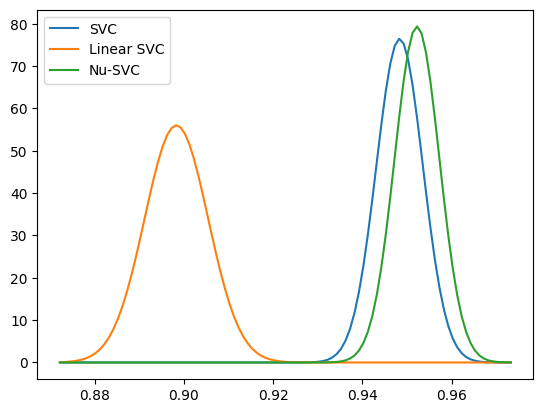

In [5]:
bound_extension = 0.01
lower_bound = min(best_SVC_lower_test_accuracy, best_LinSVC_lower_test_accuracy, best_NuSVC_lower_test_accuracy) - bound_extension
upper_bound = max(best_SVC_upper_test_accuracy, best_LinSVC_upper_test_accuracy, best_NuSVC_upper_test_accuracy) + bound_extension
data_points = np.arange(lower_bound, upper_bound, 0.001)

plt.plot(data_points, stats.norm.pdf(data_points, best_SVC_accuracy_test, np.sqrt((best_SVC_accuracy_test * (1 - best_SVC_accuracy_test)) / len(y_test))), label = 'SVC')
plt.plot(data_points, stats.norm.pdf(data_points, best_LinSVC_accuracy_test, np.sqrt((best_LinSVC_accuracy_test * (1 - best_LinSVC_accuracy_test)) / len(y_test))), label = 'Linear SVC')
plt.plot(data_points, stats.norm.pdf(data_points, best_NuSVC_accuracy_test, np.sqrt((best_NuSVC_accuracy_test * (1 - best_NuSVC_accuracy_test)) / len(y_test))), label = 'Nu-SVC')
plt.legend()

### Final Statement: SVM Classifier

Since the confidence interval of the linear SVC does not intersect with the confidence intervals of the other classifiers and has a lower accuracy, we can conclude that the linear SVC is not the best SVM classifier for this dataset. In the case of SVC and NuSVC, the confidence interval of both intersect eachother. As the mean of the NuSVC is higher it is more likely that this classifier will perform best. Hence the NuSVC classifier was chosen as the best classifier found. Nevertheless, it would be necessary to investigate the intersected area of both bell curves (SVC and NuSVC) and perform a statistical test on how confident we are on why one is more accurate than the other!<br>

# Calc3: Neural Network

To create our Classifier we used the MLPClassifier of Sklearn and for the Hyperparameter-Optimization we used GridSearchCV.<br>
We calculated the best hyperparameters separately because of time consumption and used the found parameters to create and train the final Classifier.

In [6]:
# --- Execution mandatory --- #

# Set best hyperparameter
activation = "relu"
solver = "adam"
learning_rate = "adaptive"
hidden_layer_sizes = (100, 60)
alpha = 1.5
random_state = 4
learning_rate_init = 0.001

# Create Classifier
finalNN = MLPClassifier(max_iter=250, activation=activation, solver=solver, learning_rate=learning_rate,
                    hidden_layer_sizes=hidden_layer_sizes, random_state=random_state, alpha=alpha,
                    learning_rate_init=learning_rate_init)

# Train classifier
finalNN.fit(X_train, y_train)
print("Accuracy on Training-Data: " + str(finalNN.score(X_train, y_train)*100) + "%")
print("Accuracy on Test-Data: " + str(finalNN.score(X_test, y_test)*100) + "%")

Accuracy on Training-Data: 99.90476190476191%
Accuracy on Test-Data: 93.83333333333333%


## Estimation of MLPC accuracy 

The upper and lower bound of the precision was calculated with the following formula (same as SVM above):
$$ 
\hat{\varepsilon} − c_{\delta/2} ∗ \sqrt{
    \frac{ \hat{\varepsilon} ∗ (1 − \hat{\varepsilon})}{n}}  
    − \frac{c^2_{\delta /2}}{n} 
    < \varepsilon \leq 
    \hat{\varepsilon} + c_{\delta/2} ∗ \sqrt{
    \frac{ \hat{\varepsilon} ∗ (1 − \hat{\varepsilon})}{n}}  
    + \frac{c^2_{\delta /2}}{n} 
$$
 
$\hat{\varepsilon}$ ...empirical error <br>
$\varepsilon$   ...true error <br>
$n$ ...number of samples <br>
$c_{\delta/2}$  ...quantile of normaldistibution <br>



In [7]:
MLPC_upper_bound = finalNN.score(X_test, y_test) + c_delta_half * np.sqrt((finalNN.score(X_test, y_test) * (1 - finalNN.score(X_test, y_test))) / len(y_test)) + c_delta_half ** 2 / len(y_test)
MLPC_lowe_bound = finalNN.score(X_test, y_test) - c_delta_half * np.sqrt((finalNN.score(X_test, y_test) * (1 - finalNN.score(X_test, y_test))) / len(y_test)) - c_delta_half ** 2 / len(y_test)
print(f'''
    Multi-Layer Perceptron classifier:
    upper accuracy bound: {round(MLPC_upper_bound * 100, 2)}
    mean accuracy: {round(finalNN.score(X_test, y_test) * 100, 2)}
    lower accuracy bound: {round(MLPC_lowe_bound * 100, 2)}''')


    Multi-Layer Perceptron classifier:
    upper accuracy bound: 95.16
    mean accuracy: 93.83
    lower accuracy bound: 92.51


### Plotting the results

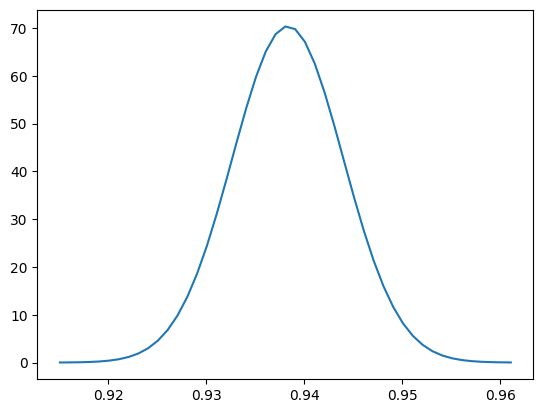

In [8]:
interval_extension = 0.01
lower_bound = MLPC_lowe_bound - interval_extension
upper_bound = MLPC_upper_bound + interval_extension

data_points = np.arange(lower_bound, upper_bound, 0.001)
plt.plot(data_points, stats.norm.pdf(data_points, finalNN.score(X_test, y_test), np.sqrt((finalNN.score(X_test, y_test) * (1 - finalNN.score(X_test, y_test))) / len(y_test))), label = 'MLPC')

# Comparison SVC and MLPC

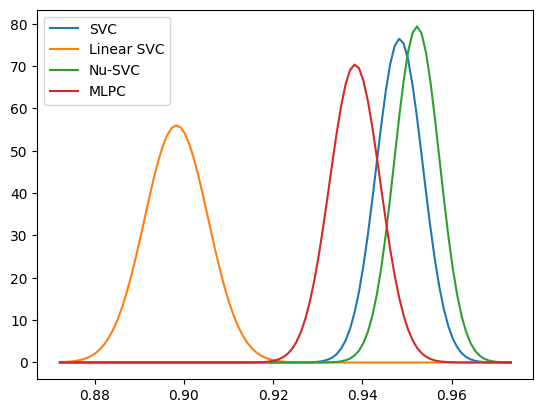

In [9]:
# To execute this cell, you need to execute every cell of Calc1, Calc2 and Calc3 first! 
interval_extension = 0.01
lower_bound = min(best_SVC_lower_test_accuracy, best_LinSVC_lower_test_accuracy, best_NuSVC_lower_test_accuracy, MLPC_lowe_bound) - interval_extension
upper_bound = max(best_SVC_upper_test_accuracy, best_LinSVC_upper_test_accuracy, best_NuSVC_upper_test_accuracy, MLPC_upper_bound) + interval_extension

data_points = np.arange(lower_bound, upper_bound, 0.001)
plt.plot(data_points, stats.norm.pdf(data_points, best_SVC_accuracy_test, np.sqrt((best_SVC_accuracy_test * (1 - best_SVC_accuracy_test)) / len(y_test))), label = 'SVC')
plt.plot(data_points, stats.norm.pdf(data_points, best_LinSVC_accuracy_test, np.sqrt((best_LinSVC_accuracy_test * (1 - best_LinSVC_accuracy_test)) / len(y_test))), label = 'Linear SVC')
plt.plot(data_points, stats.norm.pdf(data_points, best_NuSVC_accuracy_test, np.sqrt((best_NuSVC_accuracy_test * (1 - best_NuSVC_accuracy_test)) / len(y_test))), label = 'Nu-SVC')
plt.plot(data_points, stats.norm.pdf(data_points, finalNN.score(X_test, y_test), np.sqrt((finalNN.score(X_test, y_test) * (1 - finalNN.score(X_test, y_test))) / len(y_test))), label = 'MLPC')
plt.legend()

## Conclusion

According to our graph above, we can conclude that the linear SVC will perform the worst, since the confidence intervals don't intersect with any other classifier and deliver much poorer accuracies. Regarding the other classifiers, it is difficult to decide which one is the most accurate, as all of the areas intersect with one another. Therefore, it would be necessary to perform a statistical test to determine which classifier is the most precise. However, we can state that the calculated accuracies of each of our classifiers to be 95% confident.

# Final classifiers

In [ ]:
digits_SVM = best_NuSVC
digits_nn = finalNN

Make pipeline Methode für Skalierung der Daten. 
Skalierung vielleicht anders regeln.
Für finalen Classifier muss stehen, dass noch skaliert werden muss.

Finaler Klassifikator darf nicht auf Grund von Testdaten ausgewählt werden. Dazu z.B. Validierungsdaten notwendig. 

Formel für Fehler nicht korrekt. Aus Herleitung untere Schranke anschauen.
Fischer-Test möglich.
Oder einfacherer Differenzen der Fehler ansehen.